## Load data

### Modules for the stock program

In [1]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 8.3MB/s 


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout, Conv1D, Lambda, GRU
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# window_size(전일 몇일치 데이터로 예측할 것인가)를 이용해서 LSTM에 필요한 데이터셋을 만들어주는 모듈
# Module for making batched data which can be used in LSTM Machine learning. - 4 columns
def making_batch(data_x, data_y, window_size):
  # 사용법 : X_data_batch, y_data_batch = making_batch(data_x, data_y, 50)
  # ndarray 만을 넣어야 함.
  new_data_x = []
  new_data_y = []
  for i in range(len(data_x) - window_size):
    _x = data_x[i: i+window_size]
    _y = data_y[i+window_size]
    new_data_x.append(_x)
    new_data_y.append(_y)
  new_data_x = np.array(new_data_x)
  new_data_y = np.array(new_data_y)
  return new_data_x, new_data_y

# 종가만으로 batch 만드는 프로그램. - 1 columns (only the close price)
def making_batch_pr(data_y, window_size):
  new_data_x = []
  new_data_y = []
  for i in range(len(data) - window_size):
    _x = data_y[i: i+window_size] # 종가 20일치
    _y = data_y[i+window_size] # 그다음 하루의 종가
    new_data_x.append(_x) # 20일치 x에 넣고
    new_data_y.append(_y) # 1일치 y에 넣는다.
  return new_data_x, new_data_y
# window_size 만큼의 x 데이터의 결과값이 y[window_size+1] 이 된다.
# 즉 그 전날 60일만큼의 데이터가 그 다음의 주가를 예측한다.

In [4]:
# 데이터를 가져오는 함수# 데이터를 가져오는 모듈
def getting_data(need_date='all'):
  # need_date 로는 필요한 일수를 입력한다.
  samsung = pd.read_csv('./A005930.csv')
  cols = ['DAY','CUR_PR','HIGH_PR','LOW_PR','CLO_PR','FOR_STOR']
  samsung = samsung[cols]
  samsung = samsung.rename(columns = {'DAY':'date','CUR_PR':'open','HIGH_PR':'high','LOW_PR':'low','CLO_PR':'close','FOR_STOR':'volume'})
  samsung.sort_values(by='date', inplace=True)
  samsung.reset_index(drop=True, inplace=True)
  if need_date=='all':
    return samsung
  else:
    samsung = samsung[-need_date:]
    samsung.reset_index(drop=True, inplace=True)
    return samsung
  

In [5]:
# 기존 모델
def create_model_GRU(input_shape, dropout_rate,
                 num_first_LSTM_nodes, num_second_LSTM_nodes, 
                 activation='relu',learning_rate=0.00001):
  model = Sequential()
  model.add(GRU(units = num_first_LSTM_nodes, activation=activation, return_sequences = True, input_shape=input_shape))
  # LSTM 1층
  #model.add(Dropout(dropout_rate))
  # 드롭아웃 층
  model.add(GRU(units = num_second_LSTM_nodes, activation=activation))
  # LSTM 2층
  #model.add(Dropout(dropout_rate))
  model.add(Dense(units = 1)) # 출력증

  adam = Adam(lr=learning_rate)
  loss=Huber()
  model.compile(optimizer=adam, loss=loss)
  return model

In [6]:
# 모델 구조 만드는 모듈
# the usual imports for a vanilla nueral net
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow
from tensorflow.python.keras import backend as K
from keras.optimizers import Adam

In [7]:
window_size = 30

In [8]:
# 여기에 LSTM 유닛 갯수도 Bayesian Optimization 가능하도록 해주기
def create_model(learning_rate, num_dense_layers,num_input_nodes,
                 num_dense_nodes, activation, adam_decay): # adam_decay - 학습율 조정과 관련된 파라미터.
    #start the model making process and create our first layer
    model = Sequential()
    # input shape 에 (window_size, column 갯수) 를 넣어준다.
    model.add(LSTM(units = num_input_nodes, input_shape= (30,4), activation=activation, return_sequences=True))
    # input_shape 을 따로 넣어줘야 한다.
    # 첫번째 층 완료.
    model.add(LSTM(units = 10, activation=activation))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
      # 몇층으로 할지,
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(Dense(units=1))
    # 여기 노드수 1로 해야 하고, 활성화함수는 없어야 함.
    
    #setup our optimizer and compile
    adam = Adam(lr=learning_rate, decay= adam_decay)
    loss=Huber()
    model.compile(optimizer=adam, loss=loss)
    # 주식은 loss 에 Huber() 객체를 넣어주는 듯 함.
    return model


In [9]:
#imports we know we'll need
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

In [10]:
# skopt 안의 space 는 범위를 지정해주는 틀이다.
# 지정해주면 그 사이 값으로 skopt 모듈의 최적화기가 무작위로 알아서 넣어준다.
dim_learning_rate = Real(low=1e-4, high=1e-1, prior='log-uniform',
                         name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_input_nodes = Integer(low=1, high=512, name='num_input_nodes')
dim_num_dense_nodes = Integer(low=1, high=28, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu'],
                             name='activation')
dim_batch_size = Integer(low=1, high=128, name='batch_size')
dim_adam_decay = Real(low=1e-6,high=1e-2,name="adam_decay")

dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_input_nodes,
              dim_num_dense_nodes,
              dim_activation,
              dim_batch_size,
              dim_adam_decay
             ]
default_parameters = [1e-3, 1,512, 13, 'relu',64, 1e-3]

In [13]:
samsung = getting_data(700)
samsung

cols_for_scaling = ['open','high','low','close','volume']
scaler = MinMaxScaler()
scaled_samsung = scaler.fit_transform(samsung[cols_for_scaling])
scaled_samsung = pd.DataFrame(scaled_samsung, columns=cols_for_scaling, index=samsung['date'])
scaled_samsung

data_cols = ['open','high','low','volume']
target_cols = ['close']
X_data = scaled_samsung[data_cols]
y_data = scaled_samsung[target_cols]
window_size=30

new_X_data, new_y_data = making_batch(X_data.values, y_data.values, window_size)
print("X:",new_X_data.shape)
print("y:",new_y_data.shape)

input_shape = new_X_data.shape[1:]

# 최근 100일이 테스트셋, 100일 전까지의 데이터는 트레이닝셋
test_date = 100
X_train = new_X_data[:-test_date]
X_test = new_X_data[-test_date:]
y_train = new_y_data[:-test_date]
y_test = new_y_data[-test_date:]
print("X:",X_train.shape)
print("y:",y_train.shape)
# # train_data_set 과 val_data_set 을 나누자.
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

X: (670, 30, 4)
y: (670, 1)
X: (570, 30, 4)
y: (570, 1)


In [14]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_input_nodes, 
            num_dense_nodes,activation, batch_size,adam_decay):
  # fitting(훈련) 시키는 메소드인 듯.

    model = create_model(
                         learning_rate=learning_rate, # 최적화기의 학습율 지정
                         num_dense_layers=num_dense_layers, # 밀집층을 몇개의 층으로 할 거냐.
                         num_input_nodes=num_input_nodes, # 입력층의 노드 갯수 지정
                         num_dense_nodes=num_dense_nodes, # 밀집층(히든층)의 노드 갯수 지정
                         activation=activation, # 밀집층의 활성화함수로는 뭘 쓸 것이냐 (주식에선 보통 relu 씀)
                         adam_decay=adam_decay # 이건 뭐지??
                        )
    

    #named blackbox becuase it represents the structure
    # 만든 모델로 학습을 진행해준다.
    blackbox = model.fit(x=X_train, # 훈련 데이터를 넣어준다.
                        y=y_train, # 정답을 넣어준다.
                        epochs=3, # 몇회 돌릴 것인지 넣어준다.
                        batch_size=batch_size, # 배치 사이즈는 몇개로 할 것인지 (부분집합 갯수)
                        validation_split=0.15, # validation 데이터로 얼마나 분할할 것인지.
                        )
    #return the validation accuracy for the last epoch.
    loss = blackbox.history['val_loss'][-1] # val_accuracy 를 따로 담아준다. (출력하여 보기 위함)

    # Print the classification accuracy.
    print()
    print("loss: {0:.6f}".format(loss))
    print()


    # Delete the Keras model with these hyper-parameters from memory.
    del model 
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    tensorflow.compat.v1.reset_default_graph()
    # 이거 안하면 하이퍼파라미터 초기화가 안되서
    # 새로운 텐서플로우 모델이 생기지 않음.
    # 그래서 항상 clear 해줘야 함.
    
    return loss

In [15]:
# 이 코드를 텐서플로우에 항상 넣어주는게 좋다는데?
# 그래야 문제가 안일어난데.
K.clear_session()
tensorflow.compat.v1.reset_default_graph()

In [16]:
gp_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=12,
                            noise= 0.01,
                            n_jobs=-1,
                            kappa = 5,
                            x0=default_parameters)
# dimensions 안에 파라미터들이 다 들어가 있음.
# fitness 의 출력물로는 -1*정확도가 나옴.
# 즉, -1*정확도가 최소화가 되는 방향이 곧 정확도가 가장 높은 방향이다.
# 그래서 gp_minimize 라는 함수를 통해 정확도의 최대값을 구한다.

Epoch 1/3
8/8 [==============================] - 6s 159ms/step - loss: 0.0090 - val_loss: 0.0134
Epoch 2/3
8/8 [==============================] - 1s 87ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 3/3
8/8 [==============================] - 1s 93ms/step - loss: 0.0012 - val_loss: 0.0021

loss: 0.002132

Epoch 1/3
13/13 [==============================] - 3s 113ms/step - loss: 0.0631 - val_loss: 0.0052
Epoch 2/3
13/13 [==============================] - 1s 93ms/step - loss: 0.0040 - val_loss: 0.0097
Epoch 3/3
13/13 [==============================] - 1s 87ms/step - loss: 0.0057 - val_loss: 0.0228

loss: 0.022764

Epoch 1/3
8/8 [==============================] - 3s 138ms/step - loss: 0.0160 - val_loss: 0.0049
Epoch 2/3
8/8 [==============================] - 1s 94ms/step - loss: 0.0043 - val_loss: 0.0170
Epoch 3/3
8/8 [==============================] - 1s 102ms/step - loss: 0.0027 - val_loss: 0.0028

loss: 0.002760

Epoch 1/3
6/6 [==============================] - 3s 172ms/step - loss: 7688

In [17]:
gp_result.fun

0.0016167486319318414

In [18]:
gp_result

          fun: 0.0016167486319318414
    func_vals: array([2.13231728e-03, 2.27641016e-02, 2.76001659e-03, 1.41383354e-02,
       3.30016289e+04, 9.80864372e-03, 1.55363642e-02, 6.15666471e-02,
       1.68780275e-02, 1.61674863e-03, 5.58367558e-02, 2.67321002e-02])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.01, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=1892254204), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.01, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=1892254204)]
 random_state: RandomState(MT19937) at 0x7FD

In [19]:
print("best loss was " + str((gp_result.fun)))

best loss was 0.0016167486319318414


In [20]:
gp_result.x # 최적의 하이퍼파라미터를 출력해준다.

[0.002282461107544561, 2, 263, 6, 'relu', 116, 0.006574743486191048]

In [21]:
gp_result.func_vals # 최적의 하이퍼 파라미터로 했을 때 교차검증(또는 에포크수에 따른)한 정확도들을 보여준다.

array([2.13231728e-03, 2.27641016e-02, 2.76001659e-03, 1.41383354e-02,
       3.30016289e+04, 9.80864372e-03, 1.55363642e-02, 6.15666471e-02,
       1.68780275e-02, 1.61674863e-03, 5.58367558e-02, 2.67321002e-02])

In [22]:
import pandas as pd
pd.concat([pd.DataFrame(gp_result.x_iters, columns = ["learning rate","hidden layers","input layer nodes","hidden layer nodes",
                                           "activation function","batch size","adam learning rate decay"]),
(pd.Series(gp_result.func_vals, name="loss"))], axis=1)

,learning rate,hidden layers,input layer nodes,hidden layer nodes,activation function,batch size,adam learning rate decay,loss
0,0.001000,1,512,13,relu,64,0.001000,0.002132
1,0.019041,3,215,20,relu,40,0.004041,0.022764
2,0.000660,5,468,11,relu,68,0.004948,0.002760
3,0.019646,3,491,17,relu,95,0.000241,0.014138
4,0.065062,5,257,22,relu,86,0.004652,33001.628906
5,0.000132,2,509,16,relu,38,0.003183,0.009809
6,0.002553,2,306,26,relu,80,0.006220,0.015536
7,0.000177,5,147,24,relu,101,0.004768,0.061567
8,0.015162,5,186,23,relu,13,0.007343,0.016878
9,0.002282,2,263,6,relu,116,0.006575,0.001617


Creating our search parameters.
"dim_" short for dimension. Its' just a way to label our parameters.

We can search across nearly every param in a keras model. 
This code focuses on: 
* Number of Layers
* Number of Nodes per layer
* Learning Rate & Weight Decay for the Adam Optimizer
* activation functions
* batch size

The name feature allows us to use the `@use_named_args` decorator.
We must also establish default parameters. 

In [ ]:
# 이 코드를 텐서플로우에 항상 넣어주는게 좋다는데?
# 그래야 문제가 안일어난데.
K.clear_session()
tensorflow.compat.v1.reset_default_graph()

In [ ]:
# # The explanation for the parameters in gp_minimize method

# gp_result = gp_minimize(func=fitness,
#                             dimensions=dimensions,
#                             n_calls=12,
#                             noise= 0.01,
#                             n_jobs=-1,
#                             kappa = 5,
#                             x0=default_parameters)
# # dimensions 안에 파라미터들이 다 들어가 있음.
# # fitness 의 출력물로는 -1*정확도가 나옴.
# # 즉, -1*정확도가 최소화가 되는 방향이 곧 정확도가 가장 높은 방향이다.
# # 그래서 gp_minimize 라는 함수를 통해 정확도의 최대값을 구한다.

## Find our best accuracy

In [ ]:
# print("best accuracy was " + str(round(gp_result.fun *-100,2))+"%.")

### returning the parameters for the best function

In [ ]:
# gp_result.x # 최적의 하이퍼파라미터를 출력해준다.

In [ ]:
# gp_result.func_vals # 최적의 하이퍼 파라미터로 했을 때 교차검증(또는 에포크수에 따른)한 정확도들을 보여준다.

## Trying a gradient boosted search with a simpler model

In [ ]:
# Using gbrt (which is a optimization technology with boosting technology)
# gbrt_result = gbrt_minimize(func=fitness,
#                             dimensions=dimensions,
#                             n_calls=12,
#                             n_jobs=-1,
#                             x0=default_parameters)
# 이건 gp_minimize 성공하면 하는걸로

Epoch 1/3


ValueError: ignored

In [ ]:
# print("best loss was " + str((gbrt_result.fun)))

In [ ]:
# pd.concat([pd.DataFrame(gbrt_result.x_iters, columns = ["learning rate","hidden layers","input layer nodes","hidden layer nodes",
#                                            "activation function","batch size","adam learning rate decay"]),
# (pd.Series(gbrt_result.func_vals, name="loss"))], axis=1)

In [ ]:
# gbrt_result.x

In [ ]:
# K.clear_session()
# tensorflow.compat.v1.reset_default_graph()

In [ ]:
# #call our best model 
# gbrt_model = create_model(gbrt_result.x[0],gbrt_result.x[1],gbrt_result.x[2],gbrt_result.x[3],gbrt_result.x[4],gbrt_result.x[5])
# gbrt_model.summary()
# #retrain our best model architecture
# gbrt_model.fit(X_train,y_train, epochs=300)
# gbrt_model.evaluate(X_test,y_test)

In [23]:
#call our best model 
gp_model = create_model(gp_result.x[0],gp_result.x[1],gp_result.x[2],gp_result.x[3],gp_result.x[4],gp_result.x[5])
gp_model.summary()
#retrain our best model architecture
gp_model.fit(X_train,y_train, epochs=500)
gp_model.evaluate(X_test,y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 263)           281936    
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                10960     
_________________________________________________________________
layer_dense_1 (Dense)        (None, 6)                 66        
_________________________________________________________________
layer_dense_2 (Dense)        (None, 6)                 42        
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 293,011
Trainable params: 293,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
18/18 [==============================] - 3s 83ms/step - loss: 0.0235
Epoch 2/500
18/18 [================

0.2530500292778015

4/4 [==============================] - 0s 9ms/step - loss: 0.2528


Text(0, 0.5, 'price')

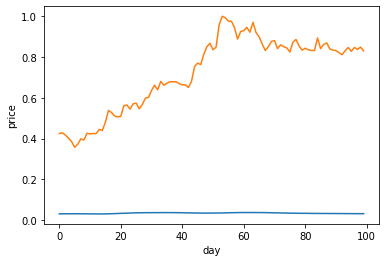

In [24]:
gp_model.fit(X_train,y_train, epochs=1000, verbose=0)
gp_model.evaluate(X_test,y_test)
pred = gp_model.predict(X_test)
pred.shape

import matplotlib.pyplot as plt

plt.plot(pred)
plt.plot(y_test)
plt.xlabel('day')
plt.ylabel('price')

In [ ]:
pred = gp_model.predict(X_test)
pred.shape

(100, 1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(pred.shape)
pred

(570, 30, 4)
(570, 1)
(100, 30, 4)
(100, 1)
(100, 1)


array([[0.00596758],
       [0.00598924],
       [0.00601284],
       [0.00602594],
       [0.00602493],
       [0.00601098],
       [0.00597686],
       [0.00592358],
       [0.00587313],
       [0.00581673],
       [0.00578247],
       [0.00577278],
       [0.00578057],
       [0.00579546],
       [0.00584598],
       [0.00592534],
       [0.00607106],
       [0.00630041],
       [0.0065636 ],
       [0.00679732],
       [0.00696377],
       [0.00708314],
       [0.007217  ],
       [0.00738061],
       [0.00751204],
       [0.00760499],
       [0.00767028],
       [0.00769378],
       [0.00767745],
       [0.00767388],
       [0.00769331],
       [0.00774807],
       [0.00784748],
       [0.00787772],
       [0.00791038],
       [0.00793122],
       [0.00793167],
       [0.00792711],
       [0.00790916],
       [0.007886  ],
       [0.00785781],
       [0.00782792],
       [0.0077872 ],
       [0.0077515 ],
       [0.00773288],
       [0.00776916],
       [0.00779358],
       [0.007

Text(0, 0.5, 'price')

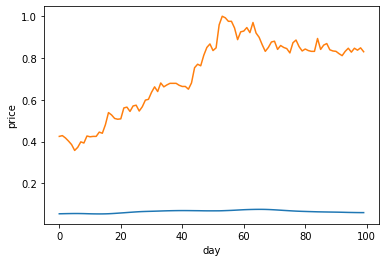

In [ ]:
import matplotlib.pyplot as plt

plt.plot(pred)
plt.plot(y_test)
plt.xlabel('day')
plt.ylabel('price')